I am calculating averages for 50 frames.
Loading file: /home/przemek/Documents/NaNbClO/long_md/NaNbCl/XDATCAR_all
 38057 frames loaded. Analyze for 50 frames.
I found 128 atoms.
Composition: {'Cl': 96, 'Na': 16, 'Nb': 16}
Unique elements: ['Cl', 'Na', 'Nb']
PDF will be caluculated for : [('Cl', 'Cl'), ('Cl', 'Na'), ('Cl', 'Nb'), ('Na', 'Na'), ('Na', 'Nb'), ('Nb', 'Nb')]
 I am workin on 50/50 frame...
Done
Mean density: 0.0385 atoms/Å^3
Writing results to: /home/przemek/Documents/NaNbClO/long_md/NaNbCl/XDATCAR_allrdf.dat
Data were sucsessfuly writen to: /home/przemek/Documents/NaNbClO/long_md/NaNbCl/XDATCAR_allrdf.dat
Mean density: 0.0385 atoms/Å^3


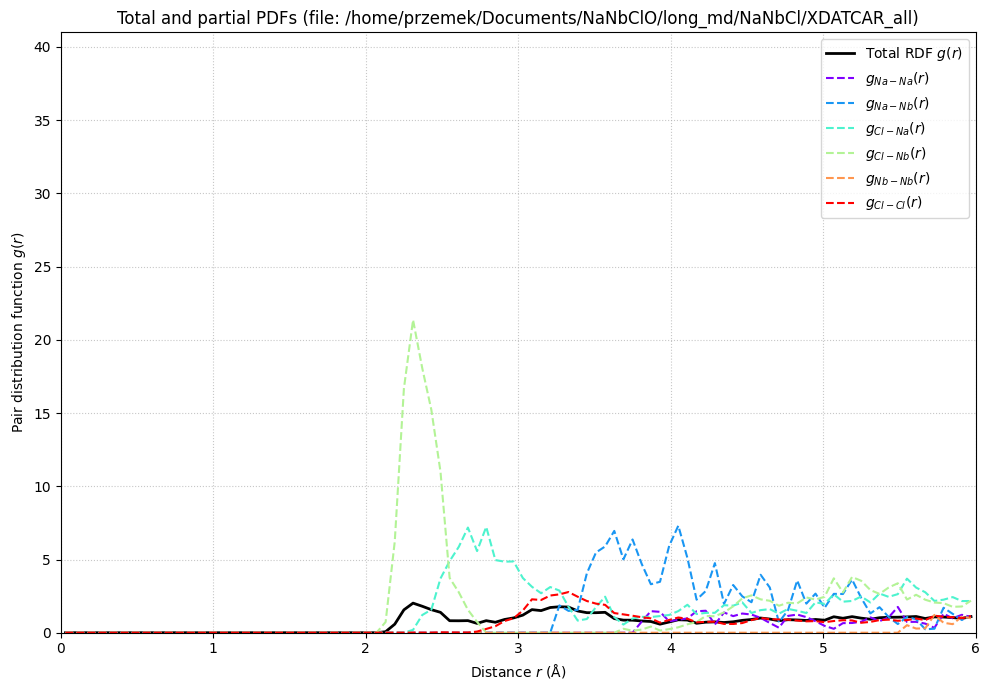

In [1]:
%matplotlib inline 
import os
import numpy as np
import matplotlib.pyplot as plt
from matscipy.neighbours import neighbour_list
from ase.io import read
from collections import defaultdict
from itertools import combinations_with_replacement

"""
The code calculates the average g(r)/RDF from the VASP XDATCAR file. You can calculate
the average of all frames or for a chosen number of the last frames. Results will be written 
into the input file directory (rdf.dat) and plotted. 
P. Dziegielewski, pdziegielewski.pl, 2025
"""
###------User part--------------------###

# --- Parameters ---
XDATCAR_FILENAME = '/home/przemek/Documents/NaNbClO/long_md/NaNbCl/XDATCAR_all'  #full path to file
MAX_DIST = 6.0              # max distance RDF [Å]
NUM_BINS = 100              # number of RDF bins
FRAMES_TO_AVERAGE = 50    # None = all frames, or a chosen number of last frames

###------End of user part--------------###


def calculate_rdfs(filename, max_dist, n_bins, frames_slice=None):
    """
Loads an XDATCAR file, then calculates and returns the total and partial Radial Distribution Functions (RDFs).

Args:
    filename (str): Path to the XDATCAR file.
    max_dist (float): Maximum distance for RDF calculation [Å].
    n_bins (int): Number of histogram bins.
    frames_slice (slice, optional): Frame selector for analysis (e.g., slice(-100, None) for the last 100 frames).
                                    None means all frames.

Returns:
    tuple: (bin_centers, total_rdf, partial_rdfs, avg_density, unique_symbols)
        bin_centers (np.array): Centers of the histogram bins [Å].
        total_rdf (np.array): Total RDF function g(r).
        partial_rdfs (dict): Dictionary {'Pair-Type': np.array}, e.g., {'Si-O': g_SiO(r)}.
        avg_density (float): Average atomic number density [atoms/Å^3].
        unique_symbols (list): List of unique element symbols.
  """
    print(f"Loading file: {filename}")
    try:
        all_frames = read(filename, index=':', format='vasp-xdatcar')
        if frames_slice:
            frames = all_frames[frames_slice]
        else:
            frames = all_frames
        print(f" {len(all_frames)} frames loaded. Analyze for {len(frames)} frames.")
        if not frames:
            raise ValueError("There is no frames to analyze.")
    except FileNotFoundError:
        print(f"Error: File {filename} does not exist")
        return None, None, None, None, None
    except Exception as e:
        print(f"Error: File exists but something is wrong {filename}: {e}")
        return None, None, None, None, None

    # Init
    total_histogram = np.zeros(n_bins, dtype=float)
    partial_histograms = defaultdict(lambda: np.zeros(n_bins, dtype=float))
    total_volume = 0.0
    total_atoms = 0 # I assume constant number of atoms
    processed_frames = 0

    # Reading the atoms based on the first frame
    first_frame = frames[0]
    num_atoms = len(first_frame)
    symbols = first_frame.get_chemical_symbols()
    unique_symbols = sorted(list(set(symbols)))
    atom_counts = {sym: symbols.count(sym) for sym in unique_symbols}
    print(f"I found {num_atoms} atoms.")
    print(f"Composition: {atom_counts}")
    print(f"Unique elements: {unique_symbols}")

    # Generating of all rdf combinations
    pair_types = list(combinations_with_replacement(unique_symbols, 2))
    print(f"PDF will be caluculated for : {pair_types}")


    # Analyzis for all frames
    for i, atoms in enumerate(frames):
        print(f"\r I am workin on {i+1}/{len(frames)} frame...", end="")

        current_volume = atoms.get_volume()
        if current_volume < 1e-6:
             print(f"\nWarning - volume of cell {i} is close to zero ({current_volume}). I'll skip it.")
             continue

        total_volume += current_volume
        total_atoms = len(atoms) 

        try:
             dists, idx_i, idx_j = neighbour_list('dij', atoms, max_dist)
        except Exception as e:
             print(f"\nError: Problem with neighbour_list in frame {i}: {e}. I'll skip it.")
             continue

        # Total PDF
        hist, bin_edges = np.histogram(dists, bins=n_bins, range=(0.0, max_dist))
        total_histogram += hist

        # Partial PDFs
        current_symbols = atoms.get_chemical_symbols()
        for k in range(len(dists)):
            sym_i = current_symbols[idx_i[k]]
            sym_j = current_symbols[idx_j[k]]
            pair_key = tuple(sorted((sym_i, sym_j)))
            bin_index = np.digitize(dists[k], bin_edges) - 1
            if 0 <= bin_index < n_bins:
                 partial_histograms[pair_key][bin_index] += 1
        processed_frames += 1

    print("\nDone")

    if processed_frames == 0:
        print("Error: I cannot analayze any frames")
        return None, None, None, None, None, None

    # --- Normalizaation ------
    avg_volume = total_volume / processed_frames
    avg_density = num_atoms / avg_volume 
    bin_width = max_dist / n_bins
    bin_centers = bin_edges[:-1] + bin_width / 2.0
    shell_volumes = (4.0 / 3.0) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
    valid_indices = (shell_volumes > 1e-9) & (avg_density > 1e-9)

    total_rdf = np.zeros_like(total_histogram, dtype=float)
    norm_factor_total = processed_frames * num_atoms * avg_density
    total_rdf[valid_indices] = total_histogram[valid_indices] / (shell_volumes[valid_indices] * norm_factor_total)

    partial_rdfs = {}
    for pair_type, hist in partial_histograms.items():
        sym1, sym2 = pair_type
        count1 = atom_counts[sym1]
        count2 = atom_counts[sym2]

        rdf = np.zeros_like(hist, dtype=float)

        if sym1 == sym2:

            if count1 > 0:
                 rho_Y = count1 / avg_volume 
                 norm_factor_partial = processed_frames * count1 * rho_Y
                 rdf[valid_indices] = hist[valid_indices] / (shell_volumes[valid_indices] * norm_factor_partial)
        else:
            if count1 > 0 and count2 > 0:
                 rho_B = count2 / avg_volume
                 norm_factor_partial = processed_frames * count1 * rho_B
                 rdf[valid_indices] = hist[valid_indices] / (shell_volumes[valid_indices] * norm_factor_partial)

        pair_key_str = f"{sym1}-{sym2}"
        partial_rdfs[pair_key_str] = rdf

    return bin_centers, total_rdf, partial_rdfs, avg_density, unique_symbols

# --- Plotting ---

def plot_rdfs(bin_centers, total_rdf, partial_rdfs, max_dist):
    plt.figure(figsize=(10, 7))

    # Total RDF
    plt.plot(bin_centers, total_rdf, label='Total RDF $g(r)$', color='black', linewidth=2)

    # Partial RDFs
    colors = plt.cm.rainbow(np.linspace(0, 1, len(partial_rdfs)))
    
    for i, (pair_type, rdf) in enumerate(partial_rdfs.items()):
        plt.plot(bin_centers, rdf, label=f'$g_{{{pair_type}}}(r)$', color=colors[i], linestyle='--')

    plt.xlabel('Distance $r$ (Å)')
    plt.ylabel('Pair distribution function $g(r)$')
    plt.title(f'Total and partial PDFs (file: {XDATCAR_FILENAME})')
    plt.xlim(0, max_dist)
    plt.ylim(0,41)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- saving to file ---
def save_rdfs_to_file(output_filepath, bin_centers, total_rdf, partial_rdfs):
    """
    Writing results to .dat file

    Args:
        output_filepath (str): full path to output file
        bin_centers (np.array): Centres of bins (column 1).
        total_rdf (np.array): Total PDF g(r) (column 2).
        partial_rdfs (dict): {'Type-Pair': np.array}.
    """
    print(f"Writing results to: {output_filepath}")

    if bin_centers is None or total_rdf is None or partial_rdfs is None:
        print("Error: There is no data to write")
        return

    try:
        header_parts = ["Distance(A)", "Total_PDF"]
        sorted_partial_keys = sorted(partial_rdfs.keys())
        for key in sorted_partial_keys:
            header_parts.append(f"Partial_{key}")
        header = "# " + "\t".join(header_parts)

        data_columns = [bin_centers, total_rdf]
        for key in sorted_partial_keys:
            data_columns.append(partial_rdfs[key])

        data_to_save = np.column_stack(data_columns)

        np.savetxt(
            output_filepath,
            data_to_save,
            header=header,
            delimiter='\t',   
            fmt='%12.6f', 
            comments=''
        )
        print(f"Data were sucsessfuly writen to: {output_filepath}")

    except IOError as e:
        print(f"Error: I cannot write {output_filepath}. Error: {e}")
    except Exception as e:
        print(f"Error: unexpected error: {e}")


##### MAIN ############
if __name__ == "__main__":
    frame_selector = None
    if FRAMES_TO_AVERAGE is not None and FRAMES_TO_AVERAGE > 0:
        frame_selector = slice(-FRAMES_TO_AVERAGE, None)
        print(f"I am calculating averages for {FRAMES_TO_AVERAGE} frames.")
    else:
        print("I am calculatedin acerages for all frames.")

    r, g_total, g_partials, density, symbols = calculate_rdfs(
        XDATCAR_FILENAME, MAX_DIST, NUM_BINS, frame_selector
    )

    if r is not None:
        print(f"Mean density: {density:.4f} atoms/Å^3")

        input_dir = os.path.dirname(os.path.abspath(XDATCAR_FILENAME)) 
        input_basename = os.path.splitext(os.path.basename(XDATCAR_FILENAME))[0] 
        OUTPUT_FILENAME_SUFFIX = 'rdf.dat'
        output_filename = input_basename + OUTPUT_FILENAME_SUFFIX 
        output_filepath = os.path.join(input_dir, output_filename)

        save_rdfs_to_file(output_filepath, r, g_total, g_partials)
        # ---------------------
        print(f"Mean density: {density:.4f} atoms/Å^3")
        plot_rdfs(r, g_total, g_partials, MAX_DIST)